In [2]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

In [40]:
# utils.py

def make_quantiles(df, v, cat):
    data = (
        df
        .filter(region='World', variable=v)
        .filter(Category=cat)
        .quantiles((0.1, 0.25, 0.5, 0.75, 0.9))
    )
    data.set_meta(cat, name='Category')
    data = data.rename({'model': {'unweighted': cat}})
    return data

def make_sequestration_plot_data(df, variables, categories_to_temp, years=[2030, 2050]):
    # pyam version of quantile data
    data = pyam.concat([
        (
            df
            .filter(region='World', variable=variable)
            .filter(Category=category)
            .quantiles((0.25, 0.5, 0.75))
            .rename(model={'unweighted': temp})
        ) for (category, temp), variable in itertools.product(categories_to_temp.items(), variables)
    ])

    # data ready for plotting
    pdata = (
        data
        .filter(year=years)
        .as_pandas(meta_cols=False)
        .assign(index=lambda x: x.year.astype(str) + ' ' + x.model)
        .drop(columns=['region', 'unit', 'year', 'model'])
        .set_index(['index', 'scenario', 'variable'])
        ['value']
        .unstack(['scenario', 'variable'])
        / 1e3
    )
    pdata = pdata.reindex(index=pdata.index[::-1]) # reverse ordering so plots are in correct order
    return data, pdata

def sequestration_plot(pdata, order=None, medians=True, stacked=True, cmap='PiYG', ax=None, legend=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    
    base, mins, maxs = pdata['quantile_0.5'], pdata['quantile_0.25'], pdata['quantile_0.75']
    if order:
        base = base[order]
    errors = [[base[c] - mins[c], maxs[c] - base[c]] for c in base.columns]
    
    base.plot.barh(xerr=errors, capsize=4, rot=0, stacked=stacked, ax=ax, cmap=cmap, alpha=0.7)
    if medians:
        ax.scatter(base.sum(axis=1), base.index, marker='s', color='k', label='Median Total')
    
    h, l = ax.get_legend_handles_labels()
    start = -1 * len(pdata.columns.get_level_values('variable').unique())
    if medians:
        start -= 1
    legend = legend or pyam.plotting.OUTSIDE_LEGEND['bottom']
    ax.legend(h[start:], l[start:], **legend)
    return ax

def share_of_cdr_data(df, categories_to_temp, offset=None):
    variables = [
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal', 
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
    ]
    dfs = []
    for cat, temp in categories_to_temp.items():
        data = (
            df
            .filter(variable=variables, region='World', year=range(2020, 2101, 10))
            .filter(Category=cat)
        )
        if offset:
            data = data.offset(year=offset)
        data = (
            data
            .divide(
                variables[1], variables[0],
                name='Land Share of Total CDR', ignore_units='fraction',
            )
            .quantiles((0.25, 0.5, 0.75))
            .rename({'model': {'unweighted': temp}})
            .timeseries()
        )
        dfs.append(data)
    return pd.concat(dfs)

# Load Data

In [4]:
data_path = pathlib.Path('../data')

In [5]:
paper_data = pd.concat([
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_data.csv'),
    pd.read_csv(data_path / 'additional_analysis_data.csv'),
])

In [6]:
ar6_data = pd.read_csv(data_path / 'AR6_Scenarios_Database_World_v1.0.csv')
ar6_data = ar6_data[ar6_data.Variable.isin(['Emissions|CO2|AFOLU'])]

In [7]:
df = pyam.IamDataFrame(pd.concat([paper_data, ar6_data]))
df.load_meta(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators for 1205 out of 1783 scenarios


In [8]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

In [9]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Cumulative Carbon Sink - Direct',
 'Cumulative Carbon Sink - Indirect',
 'Emissions|CO2|AFOLU']

# Panel 1A

In [10]:
variables = [
    'Emissions|CO2|AFOLU',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
]

data = pyam.concat([
    make_quantiles(df, v, cat)
    for v, cat in itertools.product(variables, categories_to_temp.keys())
])

In [11]:
def afolu_line_plot(data, variables, cat, ax=None, years=range(1990, 2051)):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.25*', '*0.75*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color='variable', fill_between=True, ax=ax, alpha=0.1, legend=False) #  cmap='PiYG_r',
    )
    (
        data
        .filter(variable=variables, year=years, model=cat)
        .filter(scenario=['*0.5*'])
        .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
        .plot
        .line(color='variable', ax=ax)  # cmap='PiYG_r',
    )
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-len(variables):], l[-len(variables):])
    return ax

In [12]:
color_map = {
    'Emissions|CO2|AFOLU': '#' + 'c' * 6,
    'LULUCF Emissions - Reanalyzed': '#33701a',
    'LULUCF Emissions - NGHGI Correction': '#a3176d', 
}
pyam.run_control().update({'color': {'variable': color_map}})

Text(0.5, 0, '')

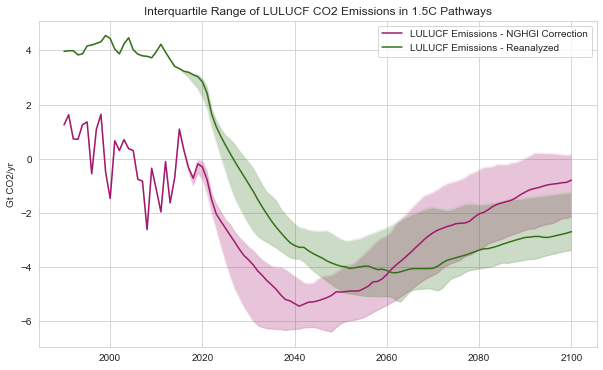

In [13]:
cat = 'C1'

variables = {
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct': 'LULUCF Emissions - Reanalyzed',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU': 'LULUCF Emissions - NGHGI Correction', 
}
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data.rename(variable=variables), variables.values(), cat, years=range(1990, 2101), ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')


## Additional Figures for SI

Text(0.5, 0, '')

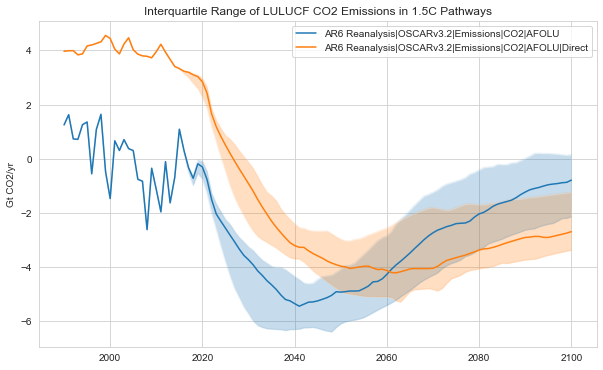

In [14]:
cat = 'C1'
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data, variables, cat, years=range(1990, 2101), ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')

Text(0.5, 0, '')

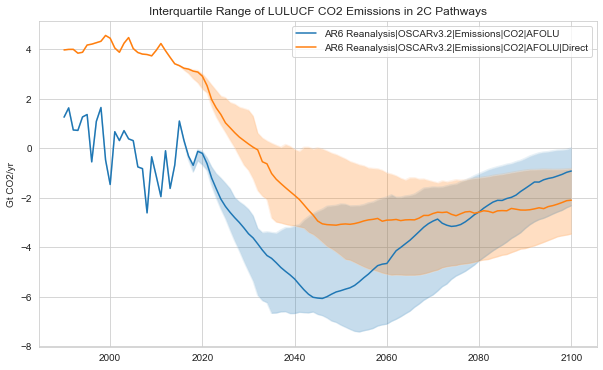

In [15]:
cat = 'C3'
fig, ax = plt.subplots(figsize=(10, 6))
afolu_line_plot(data, variables, cat, years=range(1990, 2101), ax=ax)
ax.set_title(f'Interquartile Range of LULUCF CO2 Emissions in {categories_to_temp[cat]} Pathways')
ax.set_xlabel('')

# Panel 1B

Text(0.5, 0, '')

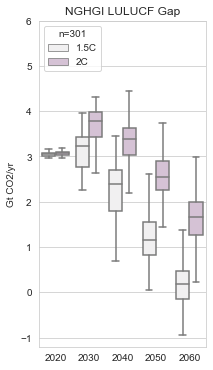

In [16]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct', 
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU', 
]
name = 'NGHGI LULUCF Gap'
fig, ax = plt.subplots(figsize=(3, 6))
(
    df
    .filter(region='World', variable=variables)
    .filter(Temperature=categories_to_temp.values())
    .filter(year=range(2020, 2061, 10))
    .subtract(variables[0], variables[1], name=name, ignore_units='Mt CO2/yr')
    .convert_unit('Mt CO2/yr', to='Gt CO2/yr', factor=1e-3)
    .plot
    .box(color='thistle', by='Temperature', ax=ax, showfliers=False)
)
ax.set_title(name)
ax.set_ylim(None, 6)
ax.set_xlabel('')

# Panel 1C

In [17]:
variables = ['Cumulative Carbon Sink - Indirect', 'Cumulative Carbon Sink - Direct']
data, pdata = make_sequestration_plot_data(df.filter(region='World'), variables, categories_to_temp)

Text(0, 0.5, '')

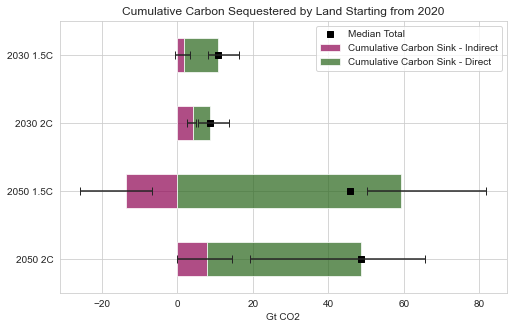

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sequestration_plot(pdata, order=variables, legend={'loc': 'best'}, ax=ax)
ax.set_title('Cumulative Carbon Sequestered by Land Starting from 2020')
ax.set_xlabel('Gt CO2')
ax.set_ylabel('')

## Figures for SI

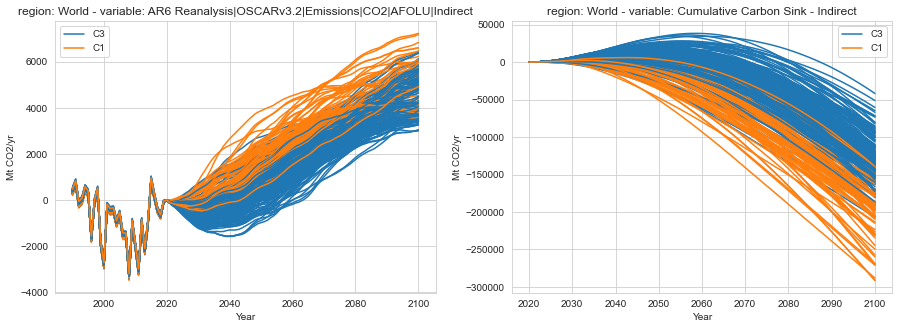

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
variables = ['AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect', 'Cumulative Carbon Sink - Indirect']
for ax, v in zip(axs, variables):
    (
        df
        .filter(variable=v, region='World')
        .filter(Category=['C1', 'C3'])
        .offset(year=2020)
        .plot
        .line(color='Category', ax=ax)
    )

In [20]:
variables = ['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect', 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct']
hist = [2015, 2020]
future = [2030, 2050, 2070, 2090]
data, pdata = make_sequestration_plot_data(df.filter(variable=variables), variables, categories_to_temp, years=hist + future)
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

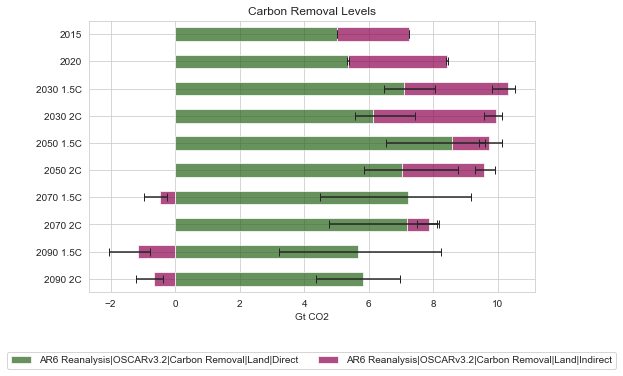

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
sequestration_plot(
    pdata, 
    medians=False, stacked=True, cmap='PiYG_r',
    legend={'loc': 'best'}, ax=ax,
)
ax.set_title('Carbon Removal Levels')
ax.set_xlabel('Gt CO2') 
ax.set_ylabel('')
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['bottom'])

# Panel 1D

In [22]:
variables = {
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal': 'Total CDR', 
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land': 'Land CDR',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land': 'Non-Land CDR',
}
hist = [2015, 2020]
data, pdata = make_sequestration_plot_data(
    df.filter(variable=variables.keys()).rename({'variable': variables}), 
    variables.values(), 
    categories_to_temp, years=hist + [2030, 2050]
)
for year in hist:
    pdata = pdata.drop(f'{year} 1.5C').rename(index={f'{year} 2C': str(year)})

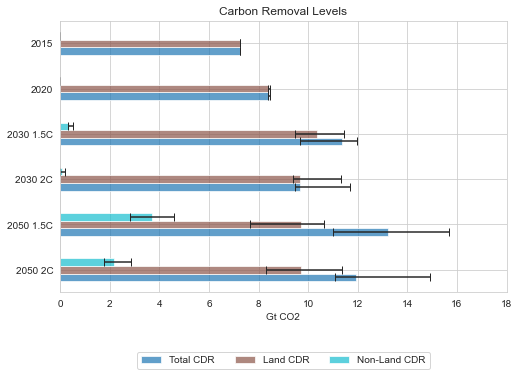

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
sequestration_plot(
    pdata, 
    medians=False, stacked=False, order=variables.values(), cmap='tab10',
    legend={'loc': 'best'}, ax=ax,
)
ax.set_title('Carbon Removal Levels')
ax.set_xlabel('Gt CO2') 
ax.set_ylabel('')
ax.set_xlim(0, 18)
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['bottom'])

# Share of CDR

In [41]:
# fraction of total cdr
total_share = share_of_cdr_data(df, categories_to_temp)
total_share.round(decimals=2)

2020  2030  2040  \
model scenario      region variable                unit                         
1.5C  quantile_0.25 World  Land Share of Total CDR fraction   1.0  0.95  0.78   
      quantile_0.5  World  Land Share of Total CDR fraction   1.0  0.97  0.86   
      quantile_0.75 World  Land Share of Total CDR fraction   1.0  0.99  0.95   
2C    quantile_0.25 World  Land Share of Total CDR fraction   1.0  0.99  0.89   
      quantile_0.5  World  Land Share of Total CDR fraction   1.0  1.00  0.95   
      quantile_0.75 World  Land Share of Total CDR fraction   1.0  1.00  0.98   

                                                             2050  2060  2070  \
model scenario      region variable                unit                         
1.5C  quantile_0.25 World  Land Share of Total CDR fraction  0.65  0.49  0.38   
      quantile_0.5  World  Land Share of Total CDR fraction  0.73  0.62  0.49   
      quantile_0.75 World  Land Share of Total CDR fraction  0.85  0.73  0.64   
2C    quantile_0.25 World  Land Share of Total CDR fraction  0.68  0.51  0.43   
      quantile_0.5  World  Land Share of Total CDR fraction  0.82  0.67  0.52   
      quantile_0.75 World  Land Share of Total CDR fraction  0.93  0.81  0.66   

                                                             2080  2090  2100  
model scenario      region variable                unit                        
1.5C  quantile_0.25 World  Land Share of Total CDR fraction  0.30  0.25  0.20  
      quantile_0.5  World  Land Share of Total CDR fraction  0.38  0.32  0.30  
      quantile_0.75 World  Land Share of Total CDR fraction  0.57  0.49  0.42  
2C    quantile_0.25 World  Land Share of Total CDR fraction  0.36  0.30  0.21  
      quantile_0.5  World  Land Share of Total CDR fraction  0.44  0.35  0.30  
      quantile_0.75 World  Land Share of Total CDR fraction  0.53  0.43  0.38

In [42]:
# fraction of *new* cdr
# negative values arise because land begins to store less carbon than it did in 2020
# accordingly, this metric only really makes sense until ~2050
new_share = share_of_cdr_data(df, categories_to_temp, offset=2020)
new_share.round(decimals=2)

2030  2040  2050  \
model scenario      region variable                unit                         
1.5C  quantile_0.25 World  Land Share of Total CDR fraction  0.76  0.36 -0.10   
      quantile_0.5  World  Land Share of Total CDR fraction  0.89  0.59  0.33   
      quantile_0.75 World  Land Share of Total CDR fraction  0.95  0.78  0.53   
2C    quantile_0.25 World  Land Share of Total CDR fraction  0.92  0.57  0.09   
      quantile_0.5  World  Land Share of Total CDR fraction  0.98  0.84  0.61   
      quantile_0.75 World  Land Share of Total CDR fraction  1.00  0.93  0.79   

                                                             2060  2070  2080  \
model scenario      region variable                unit                         
1.5C  quantile_0.25 World  Land Share of Total CDR fraction -0.37 -0.55 -0.84   
      quantile_0.5  World  Land Share of Total CDR fraction  0.07 -0.11 -0.25   
      quantile_0.75 World  Land Share of Total CDR fraction  0.27  0.12  0.18   
2C    quantile_0.25 World  Land Share of Total CDR fraction -0.20 -0.49 -0.47   
      quantile_0.5  World  Land Share of Total CDR fraction  0.30 -0.07 -0.25   
      quantile_0.75 World  Land Share of Total CDR fraction  0.51  0.13  0.01   

                                                             2090  2100  
model scenario      region variable                unit                  
1.5C  quantile_0.25 World  Land Share of Total CDR fraction -1.21 -1.09  
      quantile_0.5  World  Land Share of Total CDR fraction -0.32 -0.40  
      quantile_0.75 World  Land Share of Total CDR fraction  0.35  0.49  
2C    quantile_0.25 World  Land Share of Total CDR fraction -0.94 -1.43  
      quantile_0.5  World  Land Share of Total CDR fraction -0.45 -0.61  
      quantile_0.75 World  Land Share of Total CDR fraction -0.13 -0.20